In [1]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import textwrap
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
def likelihood_prior_func(beta = 2, alpha = 1, draw_num=(0,1,10,20,50,100)):
    '''Online Update of the Posterior distribution for a Gaussian-Gaussian conjugate prior.
    Parameter:
    beta - variance of the data likelihood (of the additive noise)
    alpha - precision value or 1/variance of the prior distribution (mean prior is assumed to be [0,0])
    draw_num - number of points collected at each instance.
    
    This function will update the prior distribution as new data points are received.
    The prior distribution will be the posterior distribution from the last iteration.'''
    
    fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

    # true (unknown) weights
    a = -0.3 # w0 - intercept
    b = 0.5  # w1 - slope
    
    # set up input space
    rangeX = [-2, 2] # range of values for the input
    step = 0.025 # distance between points
    X = np.mgrid[rangeX[0]:rangeX[1]:step] # creates a grid of values for input samples

    #initialize prior/posterior and sample data
    S0 = (1/alpha)*np.eye(2) # prior covariance matrix
    sigma = S0 # copying it so we can update it later
    mean = [0,0] # mean for prior
    
    # Draws samples from Uniform(-1,1) distribution
    draws = np.random.uniform(rangeX[0],rangeX[1],size=draw_num[-1])
    # Generate the noisy target samples
    T = a + b*draws + np.random.normal(loc=0, scale=math.sqrt(beta))

    for i in range(len(draw_num)):
        if draw_num[i]>0: #skip first image
            
            # INPUT DATA
            #Feature Matrix (Polynomial features with M=2)
            FeatureMatrix = np.array([draws[:draw_num[i]]**m for m in range(2)]).T
            #Target Values
            t = T[0:draw_num[i]]
            
            # POSTERIOR PROBABILITY
            # Covariance matrix (using the equations from last class)
            sigma = np.linalg.inv(S0 + beta*FeatureMatrix.T@FeatureMatrix)
            # Mean vector (using the equations from last class)
            mean = beta*sigma@FeatureMatrix.T@t
            
            # PARAMETER SPACE
            # create a meshgrid of possible values for w's
            w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
            
            # Define the Gaussian distribution for data likelihood
            p = multivariate_normal(mean=t[draw_num[i]-1], cov=beta)
            # Initialize the PDF for data likelihood
            out = np.empty(w0.shape)
            # For each value (w0,w1), compute the PDF for all data samples
            for j in range(len(w0)):
                out[j] = p.pdf(w0[j]+w1[j]*draws[draw_num[i]-1])
            
            # Plot the data likelihood
            ax = fig.add_subplot(*[len(draw_num),3,(i)*3+1])
            ax.pcolor(w0, w1, out)
            # Add the current value for parameters w=(w0,w1)
            ax.scatter(a,b, c='c')
            myTitle = 'data likelihood'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        # PARAMETER SPACE
        # create a meshgrid of possible values for w's
        w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
        
        # POSTERIOR PROBABILITY
        # initialize the matrix with posterior PDF values
        pos = np.empty(w1.shape + (2,))
        # for w0
        pos[:, :, 0] = w0
        # and for w1
        pos[:, :, 1] = w1
        # compute the PDF
        p = multivariate_normal(mean=mean, cov=sigma)

        #Show prior/posterior
        ax = fig.add_subplot(*[len(draw_num),3,(i)*3+2])
        ax.pcolor(w0, w1, p.pdf(pos))
        # Add the value for parameters w=(w0,w1) that MAXIMIZE THE POSTERIOR
        ax.scatter(a,b, c='c')
        myTitle = 'Prior/Posterior'
        ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        # DATA SPACE
        ax = fig.add_subplot(*[len(draw_num),3,(i)*3+3])
        for j in range(6):
            # draw sample from the prior probability to generate possible values for parameters 
            w0, w1 = np.random.multivariate_normal(mean=mean, cov=sigma)
            # Estimated labels
            t = w0 + w1*X
            # Show data space
            ax.plot(X,t)
            if draw_num[i] > 0:
                ax.scatter(FeatureMatrix[:,1], T[0:draw_num[i]])
            myTitle = 'data space'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

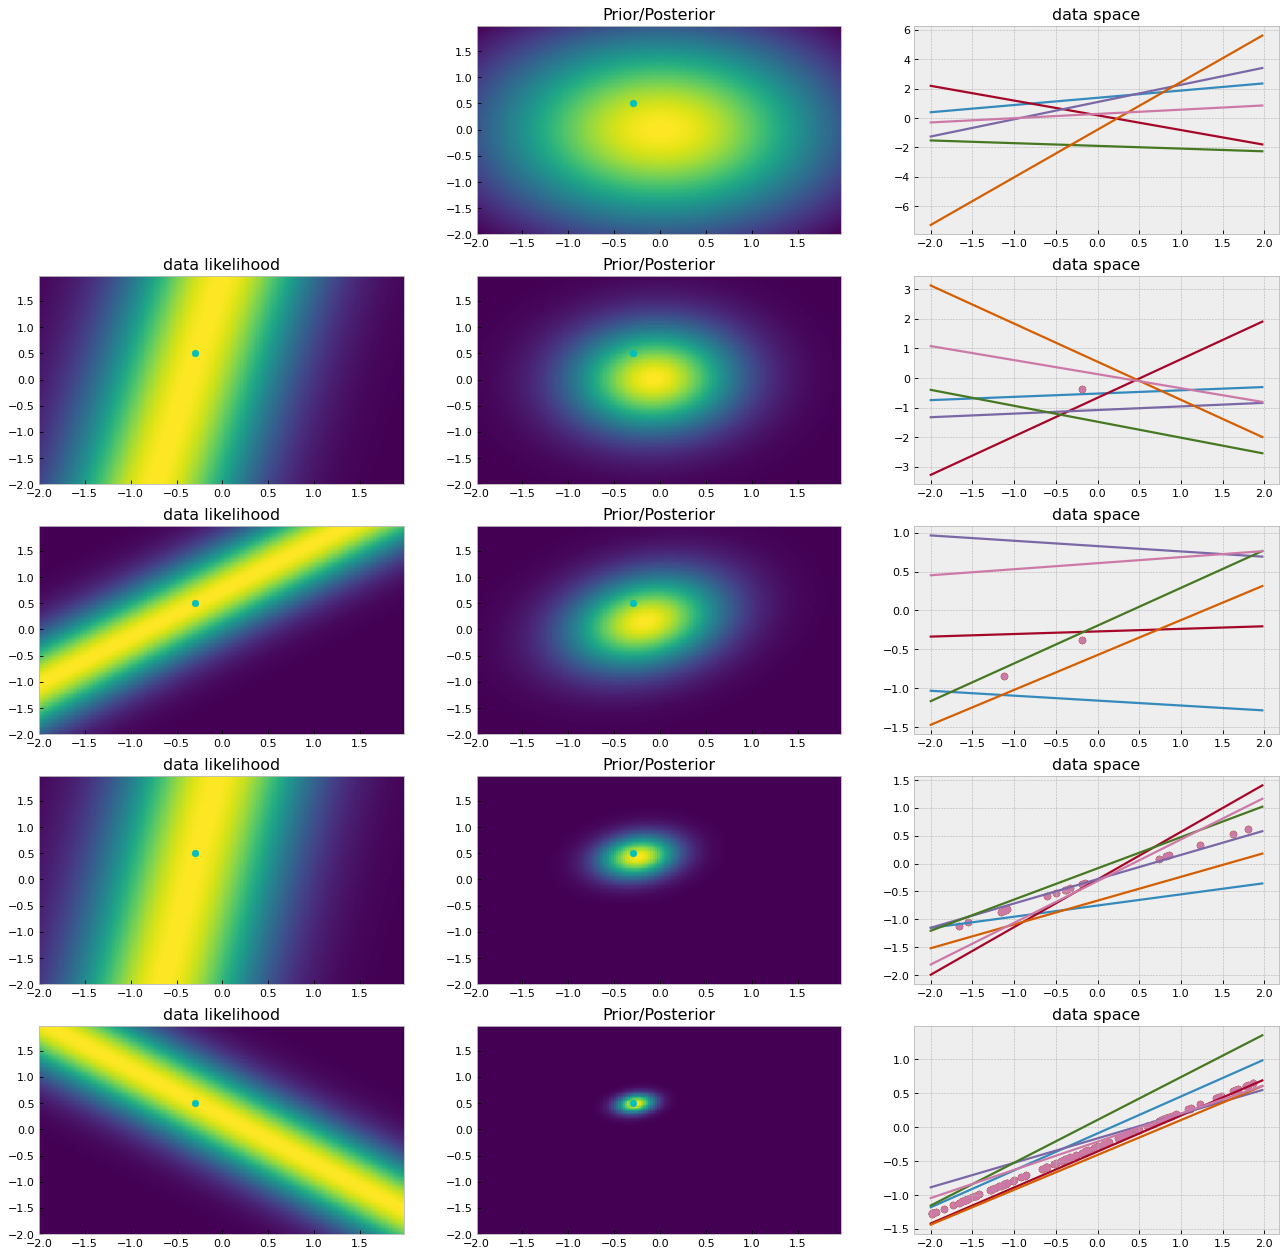

In [7]:
# Parameters
# beta - variance of the data likelihood (for the additive noise)
# alpha - precision value or 1/variance for the prior distribution
# draw_num - number of points collected at each instance

likelihood_prior_func(beta = 0.5, alpha = 1/2, draw_num=(0,1,2,20,100))

___

# Lecture 14 - Probabilistic Generative Models

Suppose we have training data from two classes, $C_1$ and $C_2$, and we would like to train a classifier to assign a label to incoming test points whether they belong to class $C_1$ or $C_2$.

There are *many* classifiers in the machine learning literature. We will cover a few in this course. Today we will focus on probabilistic generative approaches for classification.

* There are two types of probabilistic models: **discriminative** and **generative**.

A **discriminative** approach for classification is one in which we partition the feature space into regions for each class. Then, when we have a test point, we evaluate in which region it landed on and classify it accordingly.

A **generative** approach for classification is one in which we estimate the parameters for distributions that generate the data for each class. Then, when we have a test point, we can compute the posterior probability of that point belonging to each class and assign the point to the class with the highest posterior probability.

In [ ]:
def generateData(mean1, mean2, cov1, cov2, N1, N2):
    # We are generating data from two Gaussians to represent two classes
    # In practice, we would not do this - we would just have data from the problem we are trying to understand
    data_C1 = np.random.multivariate_normal(mean1, cov1, N1)
    data_C2 = np.random.multivariate_normal(mean2, cov2, N2)
    
    plt.scatter(data_C1[:,0], data_C1[:,1], c='r')
    plt.scatter(data_C2[:,0], data_C2[:,1])
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
    plt.axis([-4,4,-4,4])
    return data_C1, data_C2

In [ ]:
mean1 = [-1, -1]
mean2 = [1, 1]
cov1 = [[1,0],[0,1]]
cov2 = [[1,0],[0,1]]
N1 = 50
N2 = 100

data_C1, data_C2 = generateData(mean1, mean2, cov1, cov2, N1, N2)

In the data we generated above, we have a "red" class and a "blue" class. When we are given a test sample, we will want to assign the label of red or blue.

We can compute the **posterior probability** for class $C_1$ as follows:

$$P(C_1|x) = \frac{P(x|C_1)P(C_1)}{P(x)}$$

Understanding that the two classes, red and blue, form a partition of all possible classes, then we can utilize the *Law of Total Probability*, and obtain:

$$P(C_1|x)=\frac{P(x|C_1)P(C_1)}{P(x|C_1)P(C_1) + P(x|C_2)P(C_2)}$$

Similarly, we can compute the posterior probability for class $C_2$:

$$P(C_2|x) = \frac{P(x|C_2)P(C_2)}{P(x|C_1)P(C_1) + P(x|C_2)P(C_2)}$$

Note that $P(C_1|x) + P(C_2|x) = 1$.

## Naive Bayes Classifier

Therefore, for a given test point $\mathbf{x}^*$, our decision rule is:

$$P(C_1|\mathbf{x}^*) \underset{C_2}{\overset{C_1}{\gtrless}} P(C_2|\mathbf{x}^*)$$

Using the Bayes' rule, we can further rewrite it as:
\begin{align*}
\frac{P(\mathbf{x}^*|C_1)P(C_1)}{P(\mathbf{x}^*)} &\underset{C_2}{\overset{C_1}{\gtrless}} \frac{P(\mathbf{x}^*|C_2)P(C_2)}{P(\mathbf{x}^*)}
\end{align*}

This defines the **Naive Bayes Classifier**.

## Training a Generative Classifier

So, **to train the classifier**, what we need to do is to determine the parametric form (and its parameters values) for $p(x|C_1)$, $p(x|C_2)$, $P(C_1)$ and $p(C_2)$.

* For example, we can assume that the data samples coming from either $C_1$ and $C_2$ are distributed according to Gaussian distributions. In this case, 

$$p(x|C_k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}\exp\left\{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_k)^T\Sigma_k^{-1}(\mathbf{x}-\mathbf{\mu}_k)\right\}, \forall k=\{1,2\}$$

For this case, this defines the **Gaussian Naive Bayes Classifier**.

Or, we can consider any other parametric distribution.

* What about the $P(C_1)$ and $P(C_2)$?

We can consider the relative frequency of each class, that is, $P(C_k) = \frac{N_k}{N}$, where $N_k$ is the number of points in class $C_k$ and $N$ is the total number of samples.

## MLE Parameter Estimation Steps

For simplification, let's consider the covariance matrix $\Sigma_k$ for $k=1,2$ to be **isotropic** matrices, that is, the covariance matrix is diagonal and the element along the diagonal is the same, or: $\Sigma_k = \sigma_k^2\mathbf{I}$.

* What are the parameters? The mean and covariance of the Gaussian distribution for both classes.

Given the assumption of the Gaussian form, how would you estimate the parameters for $p(x|C_1)$ and $p(x|C_2)$? We can use **maximum likelihood estimate** for the mean and covariance, because we are looking for the parameters of the distributions that *maximize* the data likelihood!

The MLE estimate for the mean of class $C_k$ is:

$$\mathbf{\mu}_{k,\text{MLE}} = \frac{1}{N_k}\sum_{n\in C_k} \mathbf{x}_n$$

where $N_k$ is the number of training data points that belong to class $C_k$.

Assuming the classes follow a (bivariate or 2-D) Gaussian distribution and, for simplicity, let's assume the covariance matrices are **isotropic**, that is, $\Sigma_k = \sigma^2_k \mathbf{I}$.

The MLE steps for parameter estimation are:

1. Write down the observed data likelihood, $\mathcal{L}^0$

\begin{align}
\mathcal{L}^0 &= P(x_1,x_2,\dots,x_N|C_k)\\
&= \prod_{n=1}^N P(x_n|C_k),\text{ data samples are i.i.d.} \\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left\{-\frac{1}{2}(x_n-\mu_k)^T\Sigma_k^{-1}(x_n-\mu_k)\right\}\\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{d/2} |\sigma_k^2 \mathbf{I}|^{1/2}} \exp\left\{-\frac{1}{2\sigma_k^2}(x_n-\mu_k)^T\mathbf{I}(x_n-\mu_k)\right\}\\
&= \prod_{n=1}^N \frac{1}{(2\pi)^{d/2} (\sigma_k^2)^{1/2}} \exp\left\{-\frac{1}{2\sigma_k^2}(x_n-\mu_k)^T(x_n-\mu_k)\right\}
\end{align}

2. Take the log-likelihood, $\mathbf{L}$. This *trick* helps in taking derivatives.

\begin{align}
\mathcal{L} &= \ln\left(\mathcal{L}^0\right) \\
&= \sum_{n=1}^N -\frac{d}{2}\ln 2\pi - \frac{1}{2}\ln\sigma_k^2 - \frac{1}{2\sigma_k^2}(x_n-\mu_k)^T(x_n-\mu_k)
\end{align}

3. Take the derivative of the log-likelihood function with respect to the parameters of interest. For Gaussian distribution they are the mean and covariance.



\begin{align}
\frac{\partial \mathcal{L}}{\partial \mu_k} &= 0\\
\sum_{n\in C_k} \frac{1}{\sigma_k^2} (x_n - \mu_k) &= 0\\
\sum_{n\in C_k} (x_n - \mu_k) &= 0 \\
\sum_{n\in C_k} x_n - \sum_{n\in C_k} \mu_k &= 0 \\
\sum_{n\in C_k} x_n - N_k \mu_k &= 0 \\
\mu_k & = \frac{1}{N_k} \sum_{n\in C_k} x_n
\end{align}

This is the sample mean for each class. And,

\begin{align}
\frac{\partial \mathcal{L}}{\partial \sigma_k^2} &= 0\\
\sum_{n\in C_k} -\frac{1}{2\sigma_k^2} + \frac{2(x_n - \mu_k)^T(x_n - \mu_k)}{(2\sigma_k^2)^2} &=0 \\
\sum_{n\in C_k} -1 + \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{\sigma_k^2} &=0 \\
\sum_{n\in C_k} \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{\sigma_k^2} &=N_k \\
\sigma_k^2 &= \sum_{n\in C_k} \frac{(x_n - \mu_k)^T(x_n - \mu_k)}{N_k}
\end{align}

This is the sample variance for each class. Then we can create $\Sigma_k = \sigma_k^2 \mathbf{I}$, which is the (biased) sample covariance for each class.

To be continued...